# Apache Spark Pet Owners Prediction on YouTube Comments 
The given data is from YouTube comments that contains creatorID, userID, and Comments.


The goal is trying to identify whether the user is the owner of dogs or cat through the comments. The biggest challenge here is that I had to create the label through the comments by myself so that it would fit into the classification problem.

### 1. Data Exploration and Cleaning

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
from pyspark.sql.types import StructField, StringType, IntegerType, StructType
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover
from pyspark.sql.functions import col, size, udf
from pyspark.ml.feature import Word2Vec
from pyspark.sql import functions as f
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [4]:
df = spark.read.load("/FileStore/tables/animals_comments_csv-5aaff.gz", format='csv', header = True, inferschema = True)
df = df.take(2000000) # 2 million
df = spark.createDataFrame(df)

In [5]:
df = df.select("creator_name", df.userid.cast("int"), "comment")
print(df.count())
print(df.printSchema())

2000000
root
-- creator_name: string (nullable = true)
-- userid: integer (nullable = true)
-- comment: string (nullable = true)

None

In [6]:
print("Missing Value")
print("Number of NULLs in column creator_name:", df.where(col("creator_name").isNull()).count())
print("Number of NULLs in column userid:", df.where(col("userid").isNull()).count())
print("Number of NULLs in column comment:", df.where(col("comment").isNull()).count())
print("------------------------------------------------")

print("Count unique value of each column")
count_user = df.select("userid").distinct().count()
count_creator = df.select("creator_name").distinct().count()
print("Number of Users:", count_user)
print("Number of Creators:", count_creator)
print("A creator has {:.0f} users in average".format(count_user/count_creator))

Missing Value
Number of NULLs in column creator_name: 10825
Number of NULLs in column userid: 81
Number of NULLs in column comment: 242
------------------------------------------------
Count unique value of each column
Number of Users: 871639
Number of Creators: 3646
A creator has 239 users in average

### 2. Data preprocessing building classifier

In [8]:
cond = (df.comment.rlike("(^our|Our|My|my) (a|\d+|..|...|....) (cat|cats|kitten|kittens|dog|dogs|puppy|puppies)") |
        df.comment.rlike("(^our|Our|My|my) (cat|cats|kitten|kittens|dog|dogs|puppy|puppies)") |
        df.comment.rlike("(I|We) have (a|\d+|..|...|....) (cat|cats|kitten|kittens|dog|dogs|puppy|puppies)") |
        df.comment.rlike("(I|We) have (cat|cats|kitten|kittens|dog|dogs|puppy|puppies)"))
df_clean = df.withColumn('dog_cat',  cond)

num_count = df_clean.groupBy('dog_cat').count().collect()
print("Number of people who own dog or cat: ", num_count[1][1])
print("Ratio of target label / total", str(num_count[1][1] / df_clean.count() * 100), "% => data is imbalanced, need downsampling later")

Number of people who own dog or cat: 20006
Ratio of target label / total 1.0003 % => data is imbalanced, need downsampling later

In [9]:
# drop nay NULL value
df_clean = df_clean.na.drop()

# tokenized the comments
df_clean = RegexTokenizer(inputCol="comment", outputCol="text", pattern="\\W").transform(df_clean) # == [^a-zA-Z0-9_]

# remove stopwords 
df_clean = StopWordsRemover(inputCol = "text", outputCol = "filtered").transform(df_clean)

# filter out vectors that are zero
df_clean = df_clean.where(size(col("filtered")) != 0)

In [10]:
word2Vec = Word2Vec().setInputCol("filtered").setOutputCol("features").setVectorSize(128).setMinCount(0)
model = word2Vec.fit(df_clean)
df_clean = model.transform(df_clean)
df_clean.show(5)

+-------------+------+--------------------+-------+--------------------+--------------------+--------------------+
 creator_name|userid| comment|dog_cat| text| filtered| features|
+-------------+------+--------------------+-------+--------------------+--------------------+--------------------+
 Doug The Pug| 87|I shared this to ...| false|[i, shared, this,...|[shared, friends,...|[-0.0869687236845...|
 Doug The Pug| 87| Super cute 😀🐕🐶| false| [super, cute]| [super, cute]|[0.21544661559164...|
 bulletproof| 530|stop saying get e...| false|[stop, saying, ge...|[stop, saying, ge...|[-0.0122238074739...|
Meu Zoológico| 670|Tenho uma jiboia ...| false|[tenho, uma, jibo...|[tenho, uma, jibo...|[0.07767142945279...|
 ojatro| 1031|I wanna see what ...| false|[i, wanna, see, w...|[wanna, see, happ...|[-0.0571095183491...|
+-------------+------+--------------------+-------+--------------------+--------------------+--------------------+
only showing top 5 rows

In [11]:
df_clean = df_clean.select("creator_name", "userid", "text", "filtered", "features", "comment", df_clean["dog_cat"].cast("int")) 

### 3. Get insights of Data

In [13]:

# Comments contain keyword "dog" or "cat"
cond_cat_dog = (df_clean["comment"].like("%dog%") | df_clean["comment"].like("%cat%"))
df_clean2 = df_clean.select("creator_name", "userid", "comment", "dog_cat").withColumn('dog_cat_all',  cond_cat_dog)
df_clean2 = df_clean2.select("creator_name", "userid", "comment", "dog_cat", df_clean2["dog_cat_all"].cast("int"))

# collect all comments left per userId
df_clean_comment_new = df_clean2.select("creator_name", "userid", "comment", "dog_cat", "dog_cat_all").groupBy("userid").\
agg(f.concat_ws(" ", f.collect_list(df_clean2["comment"])).alias("comment_new"))
df_clean_cat = df_clean2.select("creator_name", "userid", "comment", "dog_cat", "dog_cat_all").groupBy("userid").\
agg({"dog_cat":"max", "dog_cat_all":"max"})

df_new = df_clean_comment_new.join(df_clean_cat, 'userid', 'outer')
df_new = df_new.withColumnRenamed("max(dog_cat)", "dog_cat")
df_new = df_new.withColumnRenamed("max(dog_cat_all)", "dog_cat_all")

# count the number of comments that contain dog or cat keywords
dog_cat_keyword = df_new.select("dog_cat_all").groupBy("dog_cat_all").count().toPandas()

# count the number of comments that are dog owners or cat owners
dog_cat_owner_keyword = df_new.select("dog_cat").groupBy("dog_cat").count().toPandas()

# count total number of the data
total_df_num = df_new.count()
count = np.array([dog_cat_owner_keyword["count"][0], dog_cat_keyword["count"][0]])
nobs = np.array([dog_cat_keyword["count"][0], total_df_num])
stat, pval = proportions_ztest(count, nobs, 0.05)

# compare them
print("percent of people who talk about dogs or cats", 
      str(round(float(dog_cat_keyword["count"][0]) / total_df_num * 100, 2)), "%")

print("percent of people who have dogs or cats", 
      str(round(float(dog_cat_owner_keyword["count"][0]) / total_df_num * 100, 2)), "%")

print("percent of people who talk about dogs or cats that have them", 
      str(round(float(dog_cat_owner_keyword["count"][0]) / dog_cat_keyword["count"][0] * 100, 2)), "%")

print("proportion z test:", "{0:0.3f}".format(pval))
print("---------------------------------------------------------------------")
print("people who mention dog or cat keywords are more likely to have them")

percent of people who talk about dogs or cats 12.33 %
percent of people who have dogs or cats 2.06 %
percent of people who talk about dogs or cats that have them 16.72 %
proportion z test: 0.000
---------------------------------------------------------------------
people who mention dog or cat keywords are more likely to have them

In [14]:
result2 = df_clean[df_clean["dog_cat"] == 1.0]
num_creator = result2.select("creator_name").distinct().count()
num_userid = result2.select("userid").distinct().count()
avg_num_comments = num_userid / num_creator * 1.0
print(avg_num_comments)

34.7962962962963

In [15]:
creater_visitors = df_clean.groupBy("creator_name").agg({"userid": "count"}).orderBy("count(userid)", ascending = False).toPandas()
creater_visitors_top_15 = creater_visitors["count(userid)"][:15]
creater_visitors_top_15 = creater_visitors_top_15.values

creater_visitors2 = result2.groupBy("creator_name").agg({"userid": "count"}).orderBy("count(userid)", ascending = False).toPandas()
creater_visitors2_top_15 = creater_visitors2["count(userid)"][:15]
creater_visitors2_top_15 = creater_visitors2_top_15.values

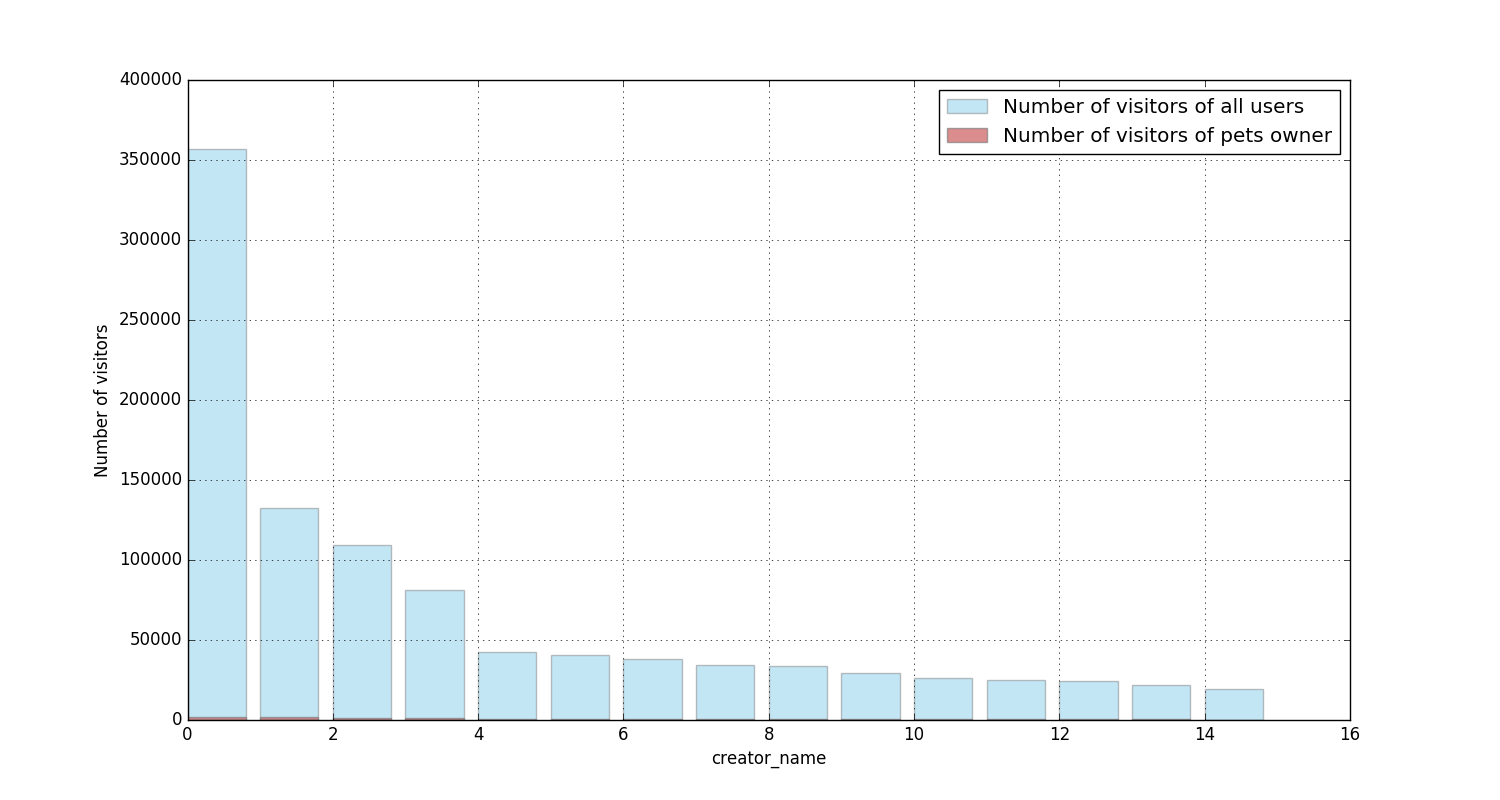

In [16]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,8))
ax = plt.subplot(111)
ax.grid(True)
ax.bar(np.arange(15), creater_visitors_top_15, alpha = 0.5, edgecolor = "grey", color = "SkyBlue")
ax.bar(np.arange(15), creater_visitors2_top_15, alpha = 0.7, edgecolor = "grey", color = "IndianRed")
ax.set_xlabel("creator_name")
ax.set_ylabel("Number of visitors")
ax.legend(["Number of visitors of all users", "Number of visitors of pets owner"])
display(fig)

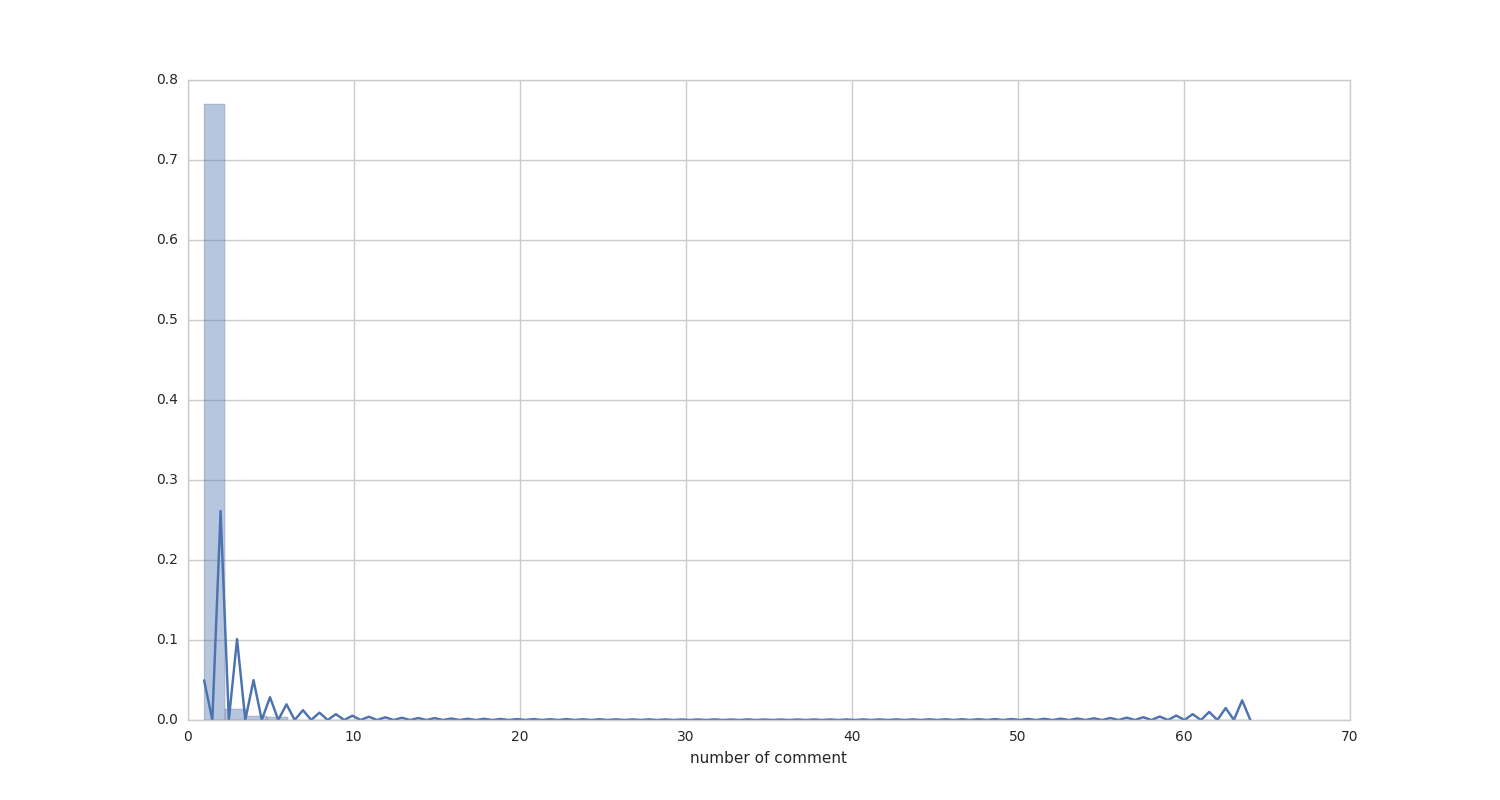

In [17]:
sns.set(color_codes=True,  style = "whitegrid")
fig = plt.figure(figsize=(15,8))
comments_from_owner = result2.groupBy("userid").agg({"comment": "count"}).orderBy("count(comment)", ascending = False).toPandas()
sns.distplot(comments_from_owner["count(comment)"])
plt.xlabel("number of comment")
display(fig)

print(comments_from_owner)

### 4. Identify Cat And Dog Owners through the Comments - Build the classifier

In [19]:
training, testing = df_clean.randomSplit([0.8, 0.2])
count_for_down_sample = df_clean.groupBy("dog_cat").count().collect()
# down sample to 1:1(dog_cat == 0:dog_cat == 1)
training2 = training.sampleBy("dog_cat", fractions={0: (count_for_down_sample[0][1] / count_for_down_sample[1][1]), 1: 1}, seed=0)

In [20]:
# LogisticRegression
lr = LogisticRegression(featuresCol = "features", labelCol = "dog_cat")

# RandomForestClassifier
rf = RandomForestClassifier(featuresCol = "features", labelCol = "dog_cat")

# GBTClassifier
gbt = GBTClassifier(featuresCol = "features", labelCol = "dog_cat")

# list for training model
model_names = ["LogisticRegression", "RandomForestClassifier", "GBTClassifier"]
model_ls = [lr, rf, gbt]
best_AUC = 0

# train and output AUC score of test set
for i, classifier in enumerate(model_ls):
  Model = classifier.fit(training2)
  r = Model.transform(testing)
  eval = BinaryClassificationEvaluator(rawPredictionCol = "prediction", labelCol = "dog_cat")
  AUC = eval.evaluate(r)
  print("AUC score of", model_names[i], ":", AUC)
  if AUC > best_AUC:
    best_AUC = AUC
    best_model = model_names[i]
# print bext model name
print("Best model without tuning is:", best_model)

AUC score of LogisticRegression : 0.8868313021076006
AUC score of RandomForestClassifier : 0.8749068979530338
AUC score of GBTClassifier : 0.8720497633260105
Best model without tuning is: LogisticRegression

In [21]:
# build the models again
lr = LogisticRegression(featuresCol = "features", labelCol = "dog_cat")
rf = RandomForestClassifier(featuresCol = "features", labelCol = "dog_cat")
gbt = GBTClassifier(featuresCol = "features", labelCol = "dog_cat")

# auto model selection and hyper parameter tuning
if best_model == "LogisticRegression":
  grid = ParamGridBuilder().addGrid(lr.maxIter, [10, 20]).addGrid(lr.regParam, [0.0, 1.0, 2.0]).build()
  eval = BinaryClassificationEvaluator(rawPredictionCol = "prediction", labelCol = "dog_cat")
  cv = CrossValidator(estimator = lr, estimatorParamMaps = grid, evaluator = eval, numFolds = 5)
  
elif best_model == "RandomForestClassifier":
  grid = ParamGridBuilder().addGrid(rf.maxDepth, [3, 5, 7]).addGrid(rf.numTrees, [10, 20, 30]).build()
  eval = BinaryClassificationEvaluator(rawPredictionCol = "prediction", labelCol = "dog_cat")
  cv = CrossValidator(estimator = rf, estimatorParamMaps = grid, evaluator = eval, numFolds = 5)
  
else: # number of trees, tree depth the learning rate as most crucial parameters.
  grid = ParamGridBuilder().addGrid(gbt.maxIter, [10, 20]).addGrid(gbt.stepSize, [0.05, 0.1, 0.2, 0.5]).addGrid(gbt.maxDepth, [3, 5, 7]).build()
  eval = BinaryClassificationEvaluator(rawPredictionCol = "prediction", labelCol = "dog_cat")
  cv = CrossValidator(estimator = gbt, estimatorParamMaps = grid, evaluator = eval, numFolds = 5)

# output best result
cvModel = cv.fit(training2)
r = cvModel.transform(testing)
AUC_best = eval.evaluate(r)
print("AUC score:", AUC_best)

# Confusion matrix
tp = r[(r.dog_cat == 1) & (r.prediction == 1)].count()
tn = r[(r.dog_cat == 0) & (r.prediction == 0)].count()
fp = r[(r.dog_cat == 0) & (r.prediction == 1)].count()
fn = r[(r.dog_cat == 1) & (r.prediction == 0)].count()
all_count = r.count()
confusion_data = {"predicted negative":[tn, fn], "predicted posotive":[fp, tp]}
confusion_matrix = pd.DataFrame(confusion_data, index = ["actual negative", "actual positive"])
print(confusion_matrix)

# ACcuracy, Precision, and Recall 
print("Total", all_count)
print("accuracy: ", float(tp + tn) / (all_count + 0.0))
print("recall: ", float(tp) / (tp + fn + 0.0))
print("precision: ", float(tp) / (tp + fp + 0.0))

AUC score: 0.8839293214496762
 predicted negative predicted posotive
actual negative 323780 48308
actual positive 416 3650
Total 376154
accuracy: 0.8704679466388766
recall: 0.897688145597639
precision: 0.07024904730744062

### 5. Report and Future work

### Situation: 
The given data is from YouTube comments that contains creatorID, userID, and Comments.


### Task: 
The goal is trying to identify whether the user is the owner of dogs or cat through the comments. The biggest challenge here is that I had to create the label through the comments by myself so that it would fit into the classification problem.


### Action:
#### 1. Data Exploration and Cleaning
1. Use Spark DataFrame to load the data
2. Check for missing values and I found that missing values only occupy a small portion. Second, it is hard to impute the missing value of ID numbers or comments in this dataset so I would drop any NULL value in the future
3. Count the number of creators and users for a brief understanding of the data

#### 2. Data preprocessing building classifier
1. Create a label(Y). Find users who own dogs or cats. In my perspective, people who have pets are more likely to say something involving these three elements: title + the number of pets + the type of their pet. For example, (I/My/Our) + (a/2/3/one) + (dog/cat). Hence, I assigned comments with this combination as dog or cats owners. I dealt with missing values later because the labeling step does not affect by the missing values and the code will be clearer if I put into further steps.
2. Data preprocessing: Now, I removed the missing values tokenized the comments, and remove stop words so that I could fit the word lists into Word2Vec 
3. Word2Vec transformation: I transformed the word lists to vectors with set VectorSize of 256. The number 256 is because just by other professional's experience and number with the power of 2 is easy for the algorithm to compute.

#### 3. Get insights of Data
Still, we need to get some insights into the data so that we can make strategies from these insights with the assistant with the predictive model.
1. See if people who mention a dog or cat are more likely to have them.
I did this analysis that if this statement holds, then people who talk about pets and yet to have them are more likely to own pets in the future. We can target them as potential audience.
2. How many comments do pets owners leave in general.
I wanted to know if there is a chance for me to segment users with different activeness
3. Top creators that have most viewers that are pet owners
I wanted to find out famous channels so that Youtube can set Ads according to the audience

#### 4. Identify Cat And Dog Owners through the Comments - Build the classifier 
1. Down-sampling: Because I was facing imbalance with rate 1 to 100 so I downsampled it to 50 percent: 50 percent
2. I implement LogisticRegression, GBTClassifier, and RandomForestClassifier without tuning the hyperparameters to see which model has the best performance
3. Use CrossValidator with Grid Search Concept for Hyper-Parameter Tuning
  
  
### Result
I had 88% of accuracy the 89% recall on the Logistic Regression. Here I emphasized more on the recall since the goal is to identify the pets owners as possible. After that, I could make sure that the three points I made on the insights could be made into practice.